In [1]:
import torch
from torch.autograd import Variable
from torch import nn, optim
import numpy as np
import matplotlib as mpt
from matplotlib import pyplot as plt

### 准备数据

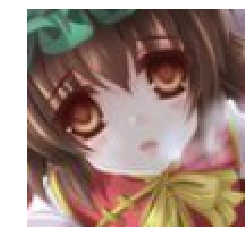

In [2]:
### 读取文件夹下所有文件
from matplotlib import image as matImg 
# from PIL import Image
x = "./faces/0000fdee4208b8b7e12074c920bc6166-0.jpg"
def read_img(path):
#     im = Image.open(path)
    im = matImg.imread(path)
#     print(im.shape)
    return im
plt.axis("off")
plt.imshow(read_img(x))

In [3]:
# 获取图片的路径
import os 
# path = "./faces"
def get_img_path(path):
    ls = os.listdir(path)
    ls = [path+"/"+x for x in ls]
    return ls

In [9]:
# 读取所有图片
import os
from matplotlib import image as matImg
path = "./faces"
def load_data(path):
    img_path = get_img_path(path) # 将文件夹下所有图片的路径存入list中
    return [read_img(x) for x in img_path] # 通过路径读取每个图片，以np.array存入list
#     print((img_path[0]))
data = load_data(path)

In [10]:
data[0]

array([[[ 89, 116, 107],
        [ 91, 118, 109],
        [ 85, 112, 103],
        ...,
        [159, 140, 159],
        [155, 136, 156],
        [164, 145, 167]],

       [[ 89, 122, 111],
        [ 82, 114, 103],
        [ 74, 106,  95],
        ...,
        [157, 138, 157],
        [162, 143, 163],
        [156, 137, 159]],

       [[ 81, 122, 108],
        [ 65, 103,  90],
        [ 57,  93,  81],
        ...,
        [152, 133, 152],
        [155, 136, 156],
        [144, 125, 147]],

       ...,

       [[224, 211, 218],
        [221, 208, 218],
        [222, 208, 223],
        ...,
        [114,  44,  46],
        [118,  46,  49],
        [112,  40,  41]],

       [[225, 214, 220],
        [221, 209, 219],
        [220, 206, 221],
        ...,
        [123,  46,  52],
        [121,  42,  47],
        [113,  33,  34]],

       [[217, 208, 213],
        [218, 206, 216],
        [221, 207, 222],
        ...,
        [121,  40,  47],
        [121,  36,  41],
        [131,  47,  45]]

### 模型超参数

In [ ]:
class Param:
    def __init__(self):
        ## 数据处理
        self.path = "./faces"
        
        ## 随机噪声数据生成
        
        ## 生成器
        self.gen_in_dim = 50
        ## 判别器
        
        ## 优化算法
        self.learning_rate = 1e-2
        ## 模型训练
        
model_param = Param()

### 生成器 ：根据随机噪声输入 得到对应输出数据

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_dim):
        super(Generator, self).__init__()
        self.FNN = nn.Sequential(
            nn.Linear(),
            nn.ReLU(),
            nn.BatchNorm1d(),
            nn.Linear(),
            nn.ReLU(),
            nn.BatchNorm1d(),
            nn.Linear(),
            nn.ReLU(),
            nn.BatchNorm1d(),
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(),
            nn.ReLU(),
            nn.MaxUnpool2d(),
            nn.ConvTranspose2d(),
            nn.ReLU(),
            nn.MaxUnpool2d(),
        )
    def forward(self, x):
        x = self.FNN(x)
        return self.conv(x)

### 判别器: 输出输入数据的判别分数

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
    def forward(self):
        pass

### 判别器损失值计算
D（x）为判别器的输出值， 同时将生成器数据和真实数据做判断    
Max-> Loss = ∑x～Pdata(x){㏒D(x)} + ∑x～Pg(x){㏒(1-D(x))}


In [ ]:
def Discrim_Loss():
    pass

### 生成器损失值计算

1. Loss的计算同上，Min -> Loss，目标策略是最小化Loss
2. 但是训练生成器的时候，并不改变判别器的参数，也就是说Loss表达式中的第一项的值并不会随着G的优化而改变 所以：

    Min -> Loss = ∑x～Pg(x){㏒(1-D(x))}

In [ ]:
def Gen_Loss():
    pass

### 模型优化算法
1. real_img 和 fake_image 通过判别器后分别得到各自的D（x）
2. 再通过损失值函数算出Loss ,通过Loss去优化模型


In [ ]:
def G_optim():
    pass


In [ ]:
def D_optim():
    pass

### 模型的训练